In [1]:
import os
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from postgres_utils import get_postgres_config

sns.set_theme(rc={
                  'axes.axisbelow': False,
                  'axes.edgecolor': 'lightgrey',
                  'axes.facecolor': 'white',
                  'axes.grid': True,
                  'axes.titlesize': 18,
                  'grid.color': 'lightgrey',
                  'axes.labelcolor': 'dimgrey',
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'figure.facecolor': 'white',
                  'lines.solid_capstyle': 'round',
                  'text.color': 'dimgrey',
                  'xtick.bottom': False,
                  'xtick.color': 'dimgrey',
                  'xtick.direction': 'out',
                  'xtick.labelsize': 15,
                  'xtick.top': False,
                  'ytick.color': 'dimgrey',
                  'ytick.labelsize': 15,
              })


%config InlineBackend.figure_format = 'retina'

In [2]:
def read_all_weight_data():
    home = os.path.expanduser('~')
    postgres_args = get_postgres_config()
    query = "SELECT * FROM WEIGHT;"
    with psycopg2.connect(**postgres_args) as conn:
        df = pd.read_sql(query, conn)
    return df


def process_weight_data(df):
    df.drop('datetime', inplace=True, axis='columns')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time'] = df['timestamp'].dt.time
    df['7-pt-MA'] = df['loss'].rolling(7).mean()
    return df


def time_dist_plot(df, bins=8):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    hours = df['timestamp'].dt.hour + df['timestamp'].dt.minute/60
    hours.name = "Hour of day"
    ax.hist(hours, bins=bins, color="#2CBFFF", ec="none")
    ax.grid(False)
    ax.set_title("Hour of day when weighed")
    return fig


def weight_loss_plot(df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.plot(df['timestamp'], df['loss'],
            label='Loss (KG)',
            marker="o",
            markersize=10,
            color="#2CBFFF",
            linewidth=3)
    ax.plot(df['timestamp'], df['7-pt-MA'],
            label="7-point MA",
            color="#F3A0F2",
            linewidth=2,
            zorder=10)
    ax.legend(bbox_to_anchor=[0.98, 0.2])
    curr_loss = df.iloc[-1]['loss']
    ax.hlines(curr_loss,
              xmin=df['timestamp'].min(),
              xmax=df['timestamp'].max(),
              linewidth=2.5,
              colors='#ffcc90',
              linestyles='--',
              label=str(curr_loss),
              zorder=10)
    ax.text(x=df['timestamp'].max(),
            y=curr_loss*1.04,
            s=f"{curr_loss}",
            weight='bold',
            size=15);
    ax.set_title(f"Total weighings: {len(df)}")
    ax.tick_params(axis="x", rotation=30)
    return fig


def get_month_start_loss(df):
    month_start_loss = (df
                        .set_index('timestamp')
                        .groupby(pd.Grouper(freq='MS'))
                        .last())
    month_start_loss = month_start_loss.reset_index()[['timestamp', 'loss']]
    month_start_loss['Month loss'] = (month_start_loss['loss']
                                      .diff()
                                      .fillna(month_start_loss['loss'])
                                      .round(2))
    month_start_loss = month_start_loss.reset_index()[['timestamp', 'Month loss']]
    month_start_loss['timestamp'] = month_start_loss['timestamp'].map(lambda t: t.strftime(format="%b-%y"))
    month_start_loss.rename(columns={'timestamp': 'Month'}, inplace=True)
    return month_start_loss

In [3]:
weight_data = read_all_weight_data()
df = process_weight_data(weight_data)

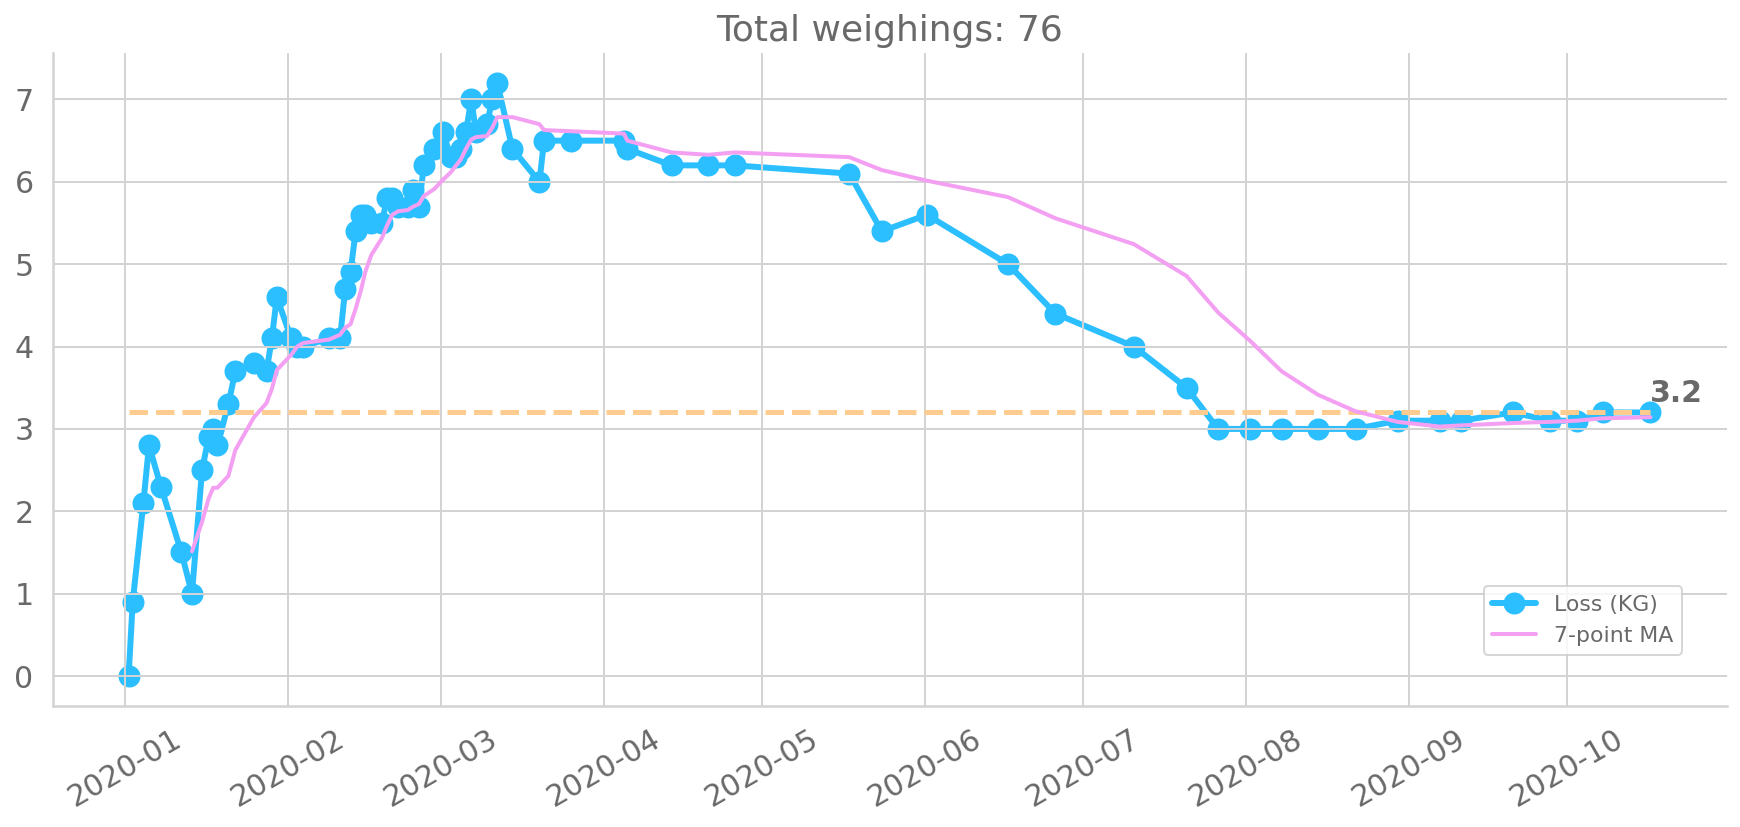

In [4]:
weight_loss_plot(df);

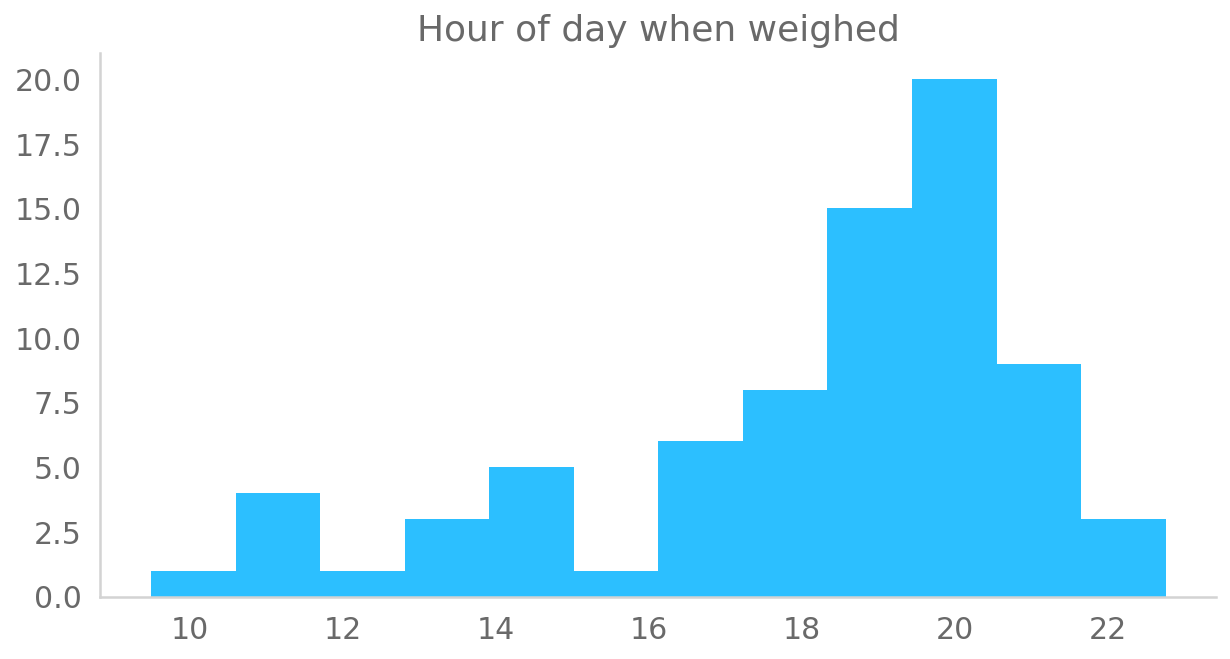

In [5]:
time_dist_plot(df, bins=12);

In [6]:
month_start_loss = get_month_start_loss(df)
month_start_loss

,Month,Month loss
0,Jan-20,4.6
1,Feb-20,1.8
2,Mar-20,0.1
3,Apr-20,-0.3
4,May-20,-0.8
5,Jun-20,-1.0
6,Jul-20,-1.4
7,Aug-20,0.1
8,Sep-20,0.0
9,Oct-20,0.1
